In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Step 1: Data Preprocessing
Load the MNIST dataset and apply a simple transformation to prepare it for training.

In [2]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.17MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.05MB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.28MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Step 2: Define a Simple Neural Network

**Neural Network Architecture**: We define a simple feedforward neural network with three layers:
* **fc1**: The first fully connected layer with 128 neurons. Since the input images are 28x28 pixels, we flatten the images into a vector of size 784 (28 * 28).
* **fc2**: The second fully connected layer with 64 neurons.
* **fc3**: The final fully connected layer with 10 neurons, one for each digit (0-9). <br>

**Activation Function**: We use ReLU (Rectified Linear Unit) after each hidden layer to introduce non-linearity. This allows the network to learn complex patterns. <br>

**Softmax Activation**: At the output layer, we use Softmax to convert the raw output into probabilities (between 0 and 1), which is useful for classification tasks.

In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # flatten the 28x28 image to 784 features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output classes for digits 0-9
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

## Step 3: Initialize the Model, Loss Function, and Optimizer

In [4]:
model = SimpleNN()
criterion = nn.CrossEntropyLoss()  # for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 4: Training and Evaluation Loop

**Training Mode**: We set the model to training mode (model.train()) to ensure that the model behaves appropriately during training, especially for layers like dropout and batch normalization. 

**Training Loop**:

1. Zero out the gradients from the previous step (optimizer.zero_grad()).

2. Pass the input through the model to get predictions (model(inputs)).

3. Calculate the loss between the predicted outputs and true labels (criterion(outputs, labels)).

4. Perform backpropagation (loss.backward()) to compute gradients.
    
5. Update the model weights using the optimizer (optimizer.step()).

* **Training Accuracy Calculation**: We use torch.max() to get the predicted class labels and compare them to the true labels to calculate training accuracy after each batch. This is accumulated over all batches for the entire epoch.

**Evaluation Mode**: After training on the current epoch, we switch the model to evaluation mode (model.eval()), which ensures layers like dropout behave correctly during testing.

**Testing Loop**:

1. We perform inference on the test dataset by passing inputs through the model (model(inputs)).
2. We compute test accuracy by comparing predicted labels to true labels, in the same way we did for training.

**Storing Accuracy**: After each epoch, we store both the training accuracy and testing accuracy in separate lists (train_accuracies and test_accuracies), which we will use for visualization.

**Epoch Output**: After each epoch, we print the loss, training accuracy, and testing accuracy to track the model’s progress.

In [6]:
# Initialize lists to track accuracy for plotting
train_accuracies = []
test_accuracies = []

# Number of epochs
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training loop
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Testing loop
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/5, Loss: 1.5066, Train Accuracy: 95.57%, Test Accuracy: 94.80%
Epoch 2/5, Loss: 1.5036, Train Accuracy: 95.84%, Test Accuracy: 95.68%
Epoch 3/5, Loss: 1.5006, Train Accuracy: 96.13%, Test Accuracy: 95.99%
Epoch 4/5, Loss: 1.4977, Train Accuracy: 96.42%, Test Accuracy: 95.91%
Epoch 5/5, Loss: 1.4962, Train Accuracy: 96.58%, Test Accuracy: 96.09%


## Step 5: Vizualization of Evaluation

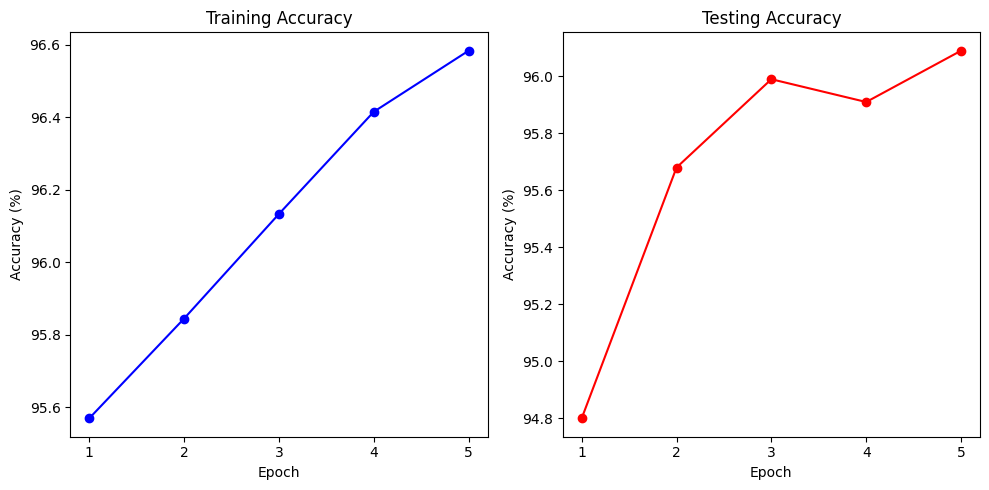

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, num_epochs + 1))

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='red', marker='o')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, num_epochs + 1))

plt.tight_layout()
plt.show()